# COSC 522 project 3
# Yangsong Gu
### Oct 08, 2021

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sympy import lambdify
from sympy import Symbol, symbols, simplify
import sympy

In [2]:
def load_data(f):
    '''
    read data, note that the last column is label. Note this function only separately load the data, not includes normailization
    args:  f --> the path or website of data

    return: X --> features
            y --> label
    '''
    data = pd.read_csv(f, delim_whitespace = True, header = 0)

    if 'pima' in f:
        data = data.replace({'No': 1, 'Yes':0})
    else:
        data = data
        
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1].astype(int)


    return X, y

In [3]:
# read and relabel the class

pi_tr_pth = 'http://www.stats.ox.ac.uk/pub/PRNN/pima.tr'
pi_te_pth = 'http://www.stats.ox.ac.uk/pub/PRNN/pima.te'
Xtrain_pi, ytrain_pi = load_data(pi_tr_pth)
Xtest_pi, ytest_pi = load_data(pi_te_pth) 


In [4]:
# standardize the data to make the features comparable or with the same scale
f_mean = Xtrain_pi.mean(axis = 0)
f_std  = Xtrain_pi.std(axis = 0)
Xtrain_pi = (Xtrain_pi - f_mean)/f_std
# standard normalization for training set
Xtest_pi= (Xtest_pi - f_mean)/f_std
ntrain = Xtrain_pi.shape[0]; ntest = Xtest_pi.shape[0]
nfe = Xtrain_pi.shape[1]
print(ntrain, nfe)
print("Training sample size {}, test sample size {}".format(Xtrain_pi.shape, Xtest_pi.shape))
nXtr = Xtrain_pi.to_numpy()
nXte = Xtest_pi.to_numpy()

200 7
Training sample size (200, 7), test sample size (332, 7)


In [7]:
def FLD(X, y):
    
    """
    input arg: X: feature data
               y: label 
    return     fX: projection of FLD
    """
    
    # coerce nunpy array
    if isinstance(X, np.ndarray):
        pass
    else: 
        X = X.to_numpy()
    # create dictionaries for mean dn covariance of different classes
    
    nrows = X.shape[0]
    nfte  = X.shape[1]
    
    mean = {}
    cov  = {}
    
    cat = np.unique(y) # number of unique categories
    Sw_mtx = np.zeros((nfte, nfte))
    
    for c in cat:
        
        arr = X[y==c]
        mean[c] = arr.mean(axis = 0)
        cov[c]  = np.cov(arr.T)
#         print(np.cov(arr.T).shape)
        Sw_mtx += (arr.shape[0] - 1) * cov[c]
    
    w = np.linalg.inv(Sw_mtx) @ (mean[0] - mean[1])
    fX =(X @ w).reshape((nrows,1))
    
    return w, fX, Sw_mtx

In [8]:
w, fXtr, Sw_mtx = FLD(nXtr, ytrain_pi)
fXte = nXte @ w            # use the projector from training set to project test set

In [9]:
def PCA(X, error, ncp):
    
    '''
    pca:
    input:  X     : standardized data
            error : error rate
            ncp   : number of component required to leave, e.g, num = 1, default is None
    return: pX    : remaining compoenent 
            P     : project vector or matrix
    '''
     # coerce nunpy array
    if isinstance(X, np.ndarray):
        pass
    else: 
        X = X.to_numpy()
    
    nfe = X.shape[1]  # number of features
    
    covX = np.cov(X.T)
    
    eigvalue, eigvector = np.linalg.eig(covX) # descending order
#     idx = np.argsort(-eigvalue)   
    idx = eigvalue.argsort()[::-1]   
    
    sorted_eigval = eigvalue[idx]
    sorted_eigvet = eigvector[:, idx]
    
    if ncp is not None:
        
        maj_eigvalue = sorted_eigval[:ncp]
        maj_eigvector = sorted_eigvet[:,:ncp]  
        pX = X @ maj_eigvector
        min_cp = ncp
        err_rate = 1 - sorted_eigval[0]/(sum(sorted_eigval))
        print("when keeping {} component, the error rate is {}, the eigenvalue is {}".format(ncp, err_rate, maj_eigvalue))
        
    else:
        err_rate = [1- (sorted_eigval[:x].sum()/(sorted_eigval.sum())) for x in range(1, nfe+1)]  # minimum cp is 1
        # find the index that can satisfy the maximum error rate 
        min_cp = np.where(np.array(err_rate) <= error)[0][0] + 1  # plus 1 because the index 0 is keeping 1 component.
#         print(np.where(np.array(err_rate) <= error)[0][0])
        print("# of components remain: ", min_cp,"to keep at-most {:.2%}, the eigenvalue is {}".format(error, sorted_eigval[:min_cp]))
        
        maj_eigvector = sorted_eigvet[:,:min_cp]
        pX = X @ maj_eigvector

    return pX, min_cp, maj_eigvector
    

In [10]:
pX1tr, num_cp, maj_vet = PCA(nXtr, None, 1)  # for one component, choose the largest eigenvalue
pX1te = nXte @ maj_vet
display(maj_vet)
pXtr, num_cp_tr, maj_vet = PCA(nXtr, 0.15, None) # for at-most 15% error rate
pXte = nXte @ maj_vet


when keeping 1 component, the error rate is 0.6558198327549878, the eigenvalue is [2.40926117]


array([[-0.36549332],
       [-0.36600186],
       [-0.41257275],
       [-0.43153727],
       [-0.39121306],
       [-0.02913468],
       [-0.47129619]])

# of components remain:  5 to keep at-most 15.00%, the eigenvalue is [2.40926117 1.49644743 0.91186762 0.79997115 0.6901352 ]


In [11]:
def histnX(fX, pX):
    
    '''
    compare the histogram of compressed data
    args  fX: output from FLD
          pX: output from PCA
    return fig , default 1 * 2 subplots
    '''
    
    hist, axs = plt.subplots(1, 2,sharey=True)
    
#     bins = int(fX.shape[0]/30)
    bins = 20
    axs[0].hist(fX,bins = bins)
    axs[0].set_xlabel('fX from FLD')
    axs[0].axvline(x= 0, color = 'red', linestyle = ':')
    axs[1].hist(pX, bins = bins)
    axs[1].set_xlabel('pX1 from PCA')
    axs[1].axvline(x=0, color = 'red', linestyle = ':')
    
#     plt.close(hist)
    
    return hist

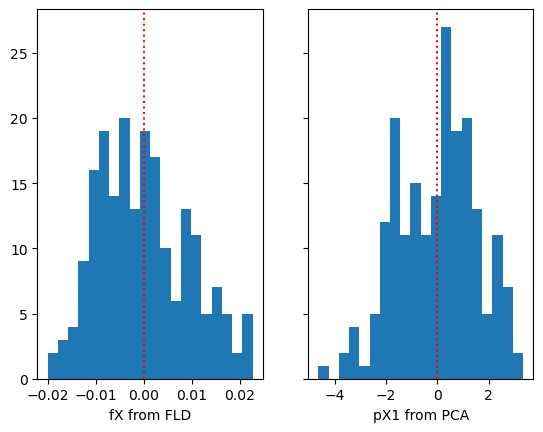

In [12]:
%matplotlib qt
hist = histnX(fXtr, pX1tr)
hist

### Case 3 on nX, fX, pX1, pX

In [13]:
import sys
sys.path.append(r'C:\2021-2022-Fall-semester\EECS522\Project')

In [14]:
from mlclass import mpp, knn, unsupervised_learning 
from mlclass import performance
%load_ext autoreload
%autoreload 2


In [15]:
pw = [1/4, 3/4]   # prior probability

In [16]:
print('Case 3 on nX ...')
MPP = mpp(nXtr, ytrain_pi, nXte, ytest_pi)
ynx, tt = MPP.case3(pw)
acc_overall, acc0, acc1 = MPP.model_evaluation(ynx)
print('run time: {:.4f} seconds'.format(tt))

Case 3 on nX ...
Overall accuracy: 76.81% 
 Classwise accuracy of class 0: 54.13% 
 Classwise accuracy of class 1: 87.89% 

run time: 0.0651 seconds


In [17]:
print('Case 3 on fX ...')
MPP = mpp(fXtr, ytrain_pi, fXte, ytest_pi)
yfx, tt = MPP.case3(pw)
acc_overall, acc0, acc1 = MPP.model_evaluation(yfx)
print('run time: {:.4f} seconds'.format(tt))

Case 3 on fX ...
Overall accuracy: 80.42% 
 Classwise accuracy of class 0: 54.13% 
 Classwise accuracy of class 1: 93.27% 

run time: 0.0070 seconds


In [18]:
print('Case 3 on pX1 ...')
MPP = mpp(pX1tr, ytrain_pi, pX1te, ytest_pi)
ypx1, tt = MPP.case3(pw)
acc_overall, acc0, acc1 = MPP.model_evaluation(ypx1)
print('run time: {:.4f} seconds'.format(tt))

Case 3 on pX1 ...
Overall accuracy: 73.19% 
 Classwise accuracy of class 0: 34.86% 
 Classwise accuracy of class 1: 91.93% 

run time: 0.0080 seconds


In [20]:
print('Case 3 on pX ...')
MPP = mpp(pXtr, ytrain_pi, pXte, ytest_pi)
ypx, tt = MPP.case3(pw)
acc_overall, acc0, acc1 = MPP.model_evaluation(ypx)
print('run time: {:.4f} seconds'.format(tt))

Case 3 on pX ...
Overall accuracy: 77.41% 
 Classwise accuracy of class 0: 57.80% 
 Classwise accuracy of class 1: 87.00% 

run time: 0.0459 seconds


### Confusion matrix of Case 3

In [21]:
Eva = performance(ynx, ytest_pi)
con_nx, roc_nx = Eva.confusion_matrix()
print('nX:\n', con_nx)
Eva = performance(yfx, ytest_pi)
con_fx, roc_fx = Eva.confusion_matrix()
print('nX:\n', con_fx)
Eva = performance(ypx1, ytest_pi)
con_px1, roc_px1 = Eva.confusion_matrix()
print('nX:\n', con_px1)
Eva = performance(ypx, ytest_pi)
con_px, roc_px = Eva.confusion_matrix()
print('nX:\n', con_px)

nX:
     0    1
0  59   50
1  27  196
nX:
     0    1
0  59   50
1  15  208
nX:
     0    1
0  38   71
1  18  205
nX:
     0    1
0  63   46
1  29  194


### KNN on nX, fX, pX1, pX

In [22]:
KNN = knn('pima',0, 30)  #kmin = 0, kmax = 30, dataname = 'pima'  just initialization
k = 12 

# convert the training set and test set to dataframe
df_nXtr = pd.DataFrame(nXtr, columns = ['D{}'.format(x) for x in range(nXtr.shape[1])])
df_nXte = pd.DataFrame(nXte, columns = ['D{}'.format(x) for x in range(nXte.shape[1])])

df_fXte = pd.DataFrame(fXte, columns = ['D1'])  # convert test sample projection to dataframe
df_fXtr = pd.DataFrame(fXtr, columns = ['D1'])  # convert training sample projection to dataframe

df_pX1te = pd.DataFrame(pX1te, columns =['D1'] )
df_pX1tr = pd.DataFrame(pX1tr, columns=['D1'])

df_pXte = pd.DataFrame(pXte, columns = ['D{}'.format(x) for x in range(pXte.shape[1])])
df_pXtr = pd.DataFrame(pXtr, columns = ['D{}'.format(x) for x in range(pXtr.shape[1])])

pima


In [23]:
#=========================== nX ===================================================
y_nx, tt_nx, acc_all_nx, acc_class_nx = KNN.predict(k, df_nXte, ytest_pi, df_nXtr, ytrain_pi)
print('Knn applied on nX:\n',acc_all_nx, acc_class_nx, 'run time:',tt_nx)
#=========================== fX ===================================================
y_fx, tt_fx, acc_all_fx, acc_class_fx = KNN.predict(k, df_fXte, ytest_pi, df_fXtr, ytrain_pi)
print('Knn applied on fX:\n', acc_all_fx, acc_class_fx, 'run time:',tt_fx)
#=========================== pX1 ===================================================
y_px1, tt_px1, acc_all_px1, acc_class_px1 = KNN.predict(k, df_pX1te, ytest_pi, df_pX1tr, ytrain_pi)
print('Knn applied on pX1:\n',acc_all_px1, acc_class_px1,'run time:',tt_px1)
#=========================== pX ===================================================
y_px, tt_px, acc_all_px, acc_class_px = KNN.predict(k, df_pXte, ytest_pi, df_pXtr, ytrain_pi)
print('Knn applied on pX:\n', acc_all_px, acc_class_px,'run time:',tt_px)

Knn applied on nX:
 0.7801204819277109    category  cate_size  class_acc
0         0        109   0.577982
1         1        223   0.878924 run time: 1.0324196815490723
Knn applied on fX:
 0.7801204819277109    category  cate_size  class_acc
0         0        109   0.642202
1         1        223   0.847534 run time: 0.6568083763122559
Knn applied on pX1:
 0.7018072289156626    category  cate_size  class_acc
0         0        109   0.495413
1         1        223   0.802691 run time: 0.6024725437164307
Knn applied on pX:
 0.7650602409638554    category  cate_size  class_acc
0         0        109   0.568807
1         1        223   0.860987 run time: 0.854680061340332


### Confusion matrix of Knn

In [24]:
Eva = performance(y_nx, ytest_pi)
con_nx, roc_nx = Eva.confusion_matrix()
print('nX:\n', con_nx)
Eva = performance(y_fx, ytest_pi)
con_fx, roc_fx = Eva.confusion_matrix()
print('nX:\n', con_fx)
Eva = performance(y_px1, ytest_pi)
con_px1, roc_px1 = Eva.confusion_matrix()
print('nX:\n', con_px1)
Eva = performance(y_px, ytest_pi)
con_px, roc_px = Eva.confusion_matrix()
print('nX:\n', con_px)

nX:
     0    1
0  63   46
1  27  196
nX:
     0    1
0  70   39
1  34  189
nX:
     0    1
0  54   55
1  44  179
nX:
     0    1
0  62   47
1  31  192


### plot ROC curve for case 3

In [25]:
tp = []
tn = []
fp = []
fn = []

for p0 in np.arange(0.0,1.01,0.05):
    
    pw = [p0, 1- p0]
    MPP = mpp(nXtr, ytrain_pi, nXte, ytest_pi)
    ypx_, tt_px_ = MPP.case3(pw)

    Eva = performance(ypx_, ytest_pi)
    con_px_, roc_px_ = Eva.confusion_matrix()
    
#     roc_px_: TN, FP, TP, FN

    fp.append(roc_px_[1])
    
    tp.append(roc_px_[2])
    
    tn.append(roc_px_[0])
    fn.append(roc_px_[3])
    
#     print(roc_px_[3] + roc_px_[2


In [26]:
def plot_roc(fp, tp):

    fig, ax = plt.subplots()
    ax.plot(fp, tp,marker = 'o',label = 'Case 3')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')
    
    return fig

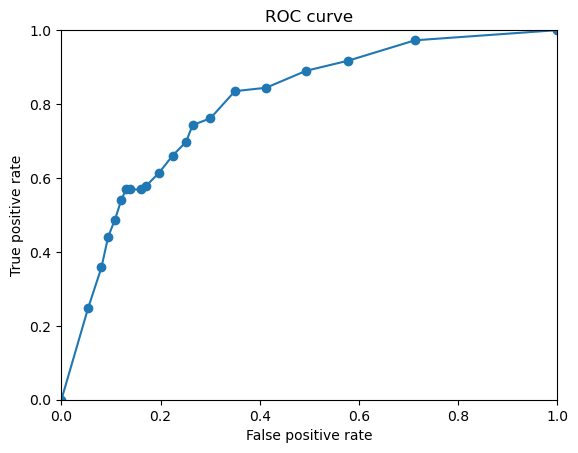

In [27]:
roc = plot_roc(fp, tp)
roc

## Task 2 Image processing

In [431]:
def new_image(rows, cols, labels, centroids):
    
    '''
    convert 2D array to RGB 3D array
    input: rows, number of rows of original image size
           cols, number of rows of original image size
           labels, class label
           centroids, class center
    '''
    newImage = np.zeros((rows * cols, 3), dtype = np.uint8)
    
    for idx, label in enumerate(labels):

        newImage[idx,:] = centroids[label,:]
    
    img_new = np.reshape(newImage, (rows, cols, 3))
        
    return img_new

In [432]:
def image_RMSE(raw_img, new_img, rows, cols):
    
    # compute the RMSE
    
    res = np.sum((raw_img - new_img)**2) / (rows * cols)
    RMSE = np.sqrt(res)
    
    return RMSE

In [428]:
pic_pth = r'../flowersm.ppm'

img = plt.imread(pic_pth)
m, n, k = img.shape
print(f'Dimension of the input image is: {img.shape}')
# change the dimension to 120x120 rows and 3 columns
X = np.reshape(img, (m * n, k))
print(f'Dimension of dataset X is: {X.shape}')

Dimension of the input image is: (120, 120, 3)
Dimension of dataset X is: (14400, 3)


In [497]:
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.xlabel('Raw picture',fontsize = 12)

Text(0.5, 0, 'Raw picture')

### KMEANS

In [434]:
kset = [256, 128, 64, 32]

new_img_kmeans = []
rmse_kmeans = []

for kk in kset:
    
    unsup = unsupervised_learning(X, kk)
    metrics, labels, centroids = unsup.Kmeans()
    
    com_image = new_image(m, n, labels, centroids)
   
    rmse = image_RMSE(img, com_image, m, n)
    new_img_kmeans.append(com_image)
    rmse_kmeans.append(rmse)

    print('Finished {}'.format(kk),'error is {}'.format(rmse))

Number of samples : 14400 256
(256, 3)
1
Run time is 28.86802649497986 seconds
Finished 256 error is 13.071316137082583
Number of samples : 14400 128
(128, 3)
1
Run time is 15.849251508712769 seconds
Finished 128 error is 13.164327323828168
Number of samples : 14400 64
(64, 3)
1
Run time is 8.793615818023682 seconds
Finished 64 error is 13.19574057961297
Number of samples : 14400 32
(32, 3)
1
Run time is 5.403280019760132 seconds
Finished 32 error is 13.417370581948363


### WTA

In [435]:
learning_rate = 0.02
error_tolerance = 0.02
new_img_wta = []
rmse_wta = []
kset = [256, 128, 64, 32]
# kset = [256]

for kk in kset:
    
    unsup = unsupervised_learning(X, kk)
    _,labels, centroids = unsup.wta(learning_rate,error_tolerance)
    
    com_image = new_image(m, n, labels, centroids)
    
    rmse = image_RMSE(img, com_image, m, n)
    
    new_img_wta.append(com_image)
    rmse_wta.append(rmse)
    
    print('Finished {}'.format(kk),'error is {}'.format(rmse))

Number of samples : 14400 256
++++++ (256, 3)
winner take all clustering, run time is 413.6393 seconds
Finished 256 error is 6.518504642767218
Number of samples : 14400 128
++++++ (128, 3)
winner take all clustering, run time is 172.4917 seconds
Finished 128 error is 7.344858367895493
Number of samples : 14400 64
++++++ (64, 3)
winner take all clustering, run time is 81.8505 seconds
Finished 64 error is 8.460291234808516
Number of samples : 14400 32
++++++ (32, 3)
winner take all clustering, run time is 30.9529 seconds
Finished 32 error is 11.290741044472384


### plot subplots for kmeans and wta

In [459]:
agg_img = new_img_kmeans + new_img_wta
agg_rmse = rmse_kmeans + rmse_wta
agg_k = kset + kset
agg_name = ['Kmeans'] * 4 + ['WTA'] * 4

fig, axs = plt.subplots(4,2,figsize = (19.2,10.8))
plt.subplots_adjust(top=0.984,
bottom=0.042,
left=0.008,
right=0.992,
hspace=0.207,
wspace=0.0)
axs = axs.flatten()
for ix, ax in enumerate(axs):

    ax.imshow(agg_img[ix])
    ax.tick_params(length = 0, axis = 'both')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('{}, K = {}, RMSE = {:.4f}'.format(agg_name[ix], agg_k[ix], agg_rmse[ix]), fontsize = 12)
#     ax.set_xlabel('dadada')